In [17]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# Import session

In [19]:
import numpy as np
import pandas as pd
from skimage.io import imread as imread
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import os

In [20]:
df = pd.read_csv("../FoodData.csv")
allergen_data = df[df.columns[-2:]]
allergen_data

,Food,Allergy
0,Almond,Nut Allergy
1,Apple,Oral Allergy Syndrome
2,Apricot,Stone Fruit Allergy
3,Artichoke,Insulin Allergy
4,Asparagus,Allium Allergy
...,...,...
179,Wheat,Gluten Allergy
180,Whey,Milk allergy / Lactose intolerance
181,White bean,Legume Allergy
182,Yam,Potato Allergy


In [21]:
allergy_food_mapping = {}

for _, row in allergen_data.iterrows():
    # group = row['Group'].lower()
    food = row['Food'].lower()
    allergy = row['Allergy']
    if not pd.isna(allergy):
        if allergy not in allergy_food_mapping:
            allergy_food_mapping[allergy] = []
        if food not in allergy_food_mapping[allergy]:
            allergy_food_mapping[allergy].append(food)
for allergy, food_items in allergy_food_mapping.items():
    print(allergy, food_items)

Nut Allergy ['almond', 'chestnut', 'ginkgo nut', 'pecan', 'walnut']
Oral Allergy Syndrome ['apple', 'avocado', 'date', 'guava', 'japanese pear', 'kiwi', 'loquat', 'mango', 'papaya', 'passion fruit', 'pear', 'pineapple', 'quince']
Stone Fruit Allergy ['apricot', 'cherry', 'japanese plum', 'mume plum', 'nectarine', 'peach', 'prune']
Insulin Allergy ['artichoke', 'chicory', 'endive', 'salsify', 'shungiku']
Allium Allergy ['asparagus', 'garlic', 'leek', 'nira', 'onion', 'shallot', 'welsh']
Histamine Allergy ['bamboo shoot', 'bonito', 'ginger', 'okra', 'spinach']
Banana Allergy ['banana']
Gluten Allergy ['barley', 'buckwheat', 'rye', 'wheat']
Legume Allergy ['bean', 'black-eyed bean', 'broad bean', 'butter bean', 'green soybean', 'kidney bean', 'lentil', 'lima bean', 'peas', 'pegia', 'sultani', 'sultapya', 'white bean']
Salicylate Allergy ['blackberry', 'blueberry', 'cranberry', 'huckleberry', 'raspberry', 'strawberry']
Broccoli allergy ['broccoli']
Cruciferous Allergy ['brussels sprouts', 

In [22]:
#Ingredients
ingredients_path = '../Ingredients101'
f = open(ingredients_path + '/Annotations/ingredients_simplified.txt', "r")
ingredients = f.read().split('\n')
f.close()

#Classes
f = open(ingredients_path + '/Annotations/classes.txt', "r")
classes = f.read().split('\n')
f.close()

#Base Ingredients
f = open(ingredients_path + '/ingredients_simplification/baseIngredients.txt', "r")
base_ing = f.read().split('\n')
f.close()

#Construct dataframe for dictionary
base_ing = base_ing[0].split(",")

new_ingredients = []
for arr in ingredients:
    arr = arr.split(",")
    new_ingredients.append(arr)
    
df = pd.DataFrame({'ingredients': new_ingredients, 'target': classes})
food_df = df[:-1]
pd.set_option('display.max_colwidth', None)
food_df

,ingredients,target
0,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie
1,"[baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili]",baby_back_ribs
2,"[nut, cinnamon, bread, butter, phyllo dough, sugar, honey, lemon, baklava]",baklava
3,"[beef, lemon, gin, salt, pepper, baby arugula, asiago]",beef_carpaccio
4,"[fat, steak, gin, shallot, parsley, capers, worcestershire, egg, black pepper, crostini]",beef_tartare
...,...,...
96,"[onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime]",tacos
97,"[flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese]",takoyaki
98,"[egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa]",tiramisu
99,"[sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber]",tuna_tartare


In [23]:
# !pip install sentence-transformers

nlpModel = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def check_allergies(ingredient, allergens):
    for allergy, allergens_list in allergy_food_mapping.items():
        for allergen in allergens_list:
            similarity = util.pytorch_cos_sim(nlpModel.encode(ingredient), nlpModel.encode(allergen)).item()
            if similarity > 0.85 and allergen not in allergens:
                allergens.add(allergen)

def process_row(row):
    allergens = set()
    for ingredient in row['ingredients']:
        check_allergies(ingredient, allergens)
    row['allergens'] = list(allergens)
    return row
food_df = food_df.apply(process_row, axis=1)
food_df

,ingredients,target,allergens
0,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[sugar, apple, butter]"
1,"[baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili]",baby_back_ribs,[apple]
2,"[nut, cinnamon, bread, butter, phyllo dough, sugar, honey, lemon, baklava]",baklava,"[sugar, lemon, butter, honey]"
3,"[beef, lemon, gin, salt, pepper, baby arugula, asiago]",beef_carpaccio,"[sweet pepper, lemon]"
4,"[fat, steak, gin, shallot, parsley, capers, worcestershire, egg, black pepper, crostini]",beef_tartare,"[parsley, eggs, shallot]"
...,...,...,...
96,"[onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime]",tacos,"[sugar, lime, onion, garlic]"
97,"[flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese]",takoyaki,"[eggs, soybean, onion, cheese]"
98,"[egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa]",tiramisu,"[eggs, sugar]"
99,"[sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber]",tuna_tartare,"[tomato, soybean]"


In [24]:
#train
f = open(ingredients_path + '/Annotations/train_images.txt', "r")
train_images = f.read().split('\n')
f.close()
f = open(ingredients_path + '/Annotations/train_labels.txt', "r")
train_labels = f.read().split('\n')
f.close()

#val
f = open(ingredients_path + '/Annotations/val_images.txt', "r")
val_images = f.read().split('\n')
f.close()
f = open(ingredients_path + '/Annotations/val_labels.txt', "r")
val_labels = f.read().split('\n')
f.close()

#test
f = open(ingredients_path + '/Annotations/test_images.txt', "r")
test_images = f.read().split('\n')
f.close()
f = open(ingredients_path + '/Annotations/test_labels.txt', "r")
test_labels = f.read().split('\n')
f.close()

food101_path = '../archive'
image_path = food101_path + '/images/'

train_images = [image_path + s + ".jpg" for s in train_images]
train_img_df = pd.DataFrame({'path': train_images, 'class_id': train_labels})

val_images = [image_path + s + ".jpg" for s in val_images]
val_img_df = pd.DataFrame({'path': val_images, 'class_id': val_labels})

test_images = [image_path + s + ".jpg" for s in test_images]
test_img_df = pd.DataFrame({'path': test_images, 'class_id': test_labels})

train_img_df = train_img_df[:-1]
val_img_df = val_img_df[:-1]
test_img_df = test_img_df[:-1]
test_img_df

,path,class_id
0,../archive/images/apple_pie/1011328.jpg,0
1,../archive/images/apple_pie/101251.jpg,0
2,../archive/images/apple_pie/1034399.jpg,0
3,../archive/images/apple_pie/103801.jpg,0
4,../archive/images/apple_pie/1038694.jpg,0
...,...,...
25245,../archive/images/waffles/942009.jpg,100
25246,../archive/images/waffles/954028.jpg,100
25247,../archive/images/waffles/96181.jpg,100
25248,../archive/images/waffles/97015.jpg,100


In [25]:
train_img_df.loc[:, 'class_name'] = train_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
val_img_df.loc[:, 'class_name'] = val_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df.loc[:, 'class_name'] = test_img_df['path'].map(lambda x: os.path.split(os.path.dirname(x))[-1])
test_img_df

,path,class_id,class_name
0,../archive/images/apple_pie/1011328.jpg,0,apple_pie
1,../archive/images/apple_pie/101251.jpg,0,apple_pie
2,../archive/images/apple_pie/1034399.jpg,0,apple_pie
3,../archive/images/apple_pie/103801.jpg,0,apple_pie
4,../archive/images/apple_pie/1038694.jpg,0,apple_pie
...,...,...,...
25245,../archive/images/waffles/942009.jpg,100,waffles
25246,../archive/images/waffles/954028.jpg,100,waffles
25247,../archive/images/waffles/96181.jpg,100,waffles
25248,../archive/images/waffles/97015.jpg,100,waffles


In [26]:
allergens = food_df['allergens'].explode().dropna().unique().tolist()
allergens, len(allergens)

(['sugar',
  'apple',
  'butter',
  'lemon',
  'honey',
  'sweet pepper',
  'parsley',
  'eggs',
  'shallot',
  'spinach',
  'milk',
  'soybean',
  'carrot',
  'garlic',
  'onion',
  'cheese',
  'lettuce ',
  'almond',
  'tomato',
  'lime',
  'avocado',
  'peas',
  'chicken',
  'sweet potato',
  'potato',
  'celery',
  'rice',
  'cherry',
  'salmon',
  'cabbage',
  'duck',
  'orange',
  'strawberry'],
 33)

In [27]:
def prepare_dataset(df):
    result_df = pd.merge(df, food_df, how='left', left_on='class_name', right_on='target')
    for allergen in allergens:
        result_df[allergen] = result_df['allergens'].apply(lambda x: 1 if allergen in x else 0)
    return result_df
train_df = prepare_dataset(train_img_df)
train_df

,path,class_id,class_name,ingredients,target,allergens,sugar,apple,butter,lemon,...,sweet potato,potato,celery,rice,cherry,salmon,cabbage,duck,orange,strawberry
0,../archive/images/apple_pie/1005649.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[sugar, apple, butter]",1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,../archive/images/apple_pie/1014775.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[sugar, apple, butter]",1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,../archive/images/apple_pie/1026328.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[sugar, apple, butter]",1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,../archive/images/apple_pie/1028787.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[sugar, apple, butter]",1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,../archive/images/apple_pie/1043283.jpg,0,apple_pie,"[butter, flour, sugar, brown sugar, apple, cinnamon, nut]",apple_pie,"[sugar, apple, butter]",1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68170,../archive/images/waffles/981485.jpg,100,waffles,"[egg, salt, sugar, vanilla, butter, flour, baking, milk]",waffles,"[butter, eggs, sugar, milk]",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68171,../archive/images/waffles/98238.jpg,100,waffles,"[egg, salt, sugar, vanilla, butter, flour, baking, milk]",waffles,"[butter, eggs, sugar, milk]",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68172,../archive/images/waffles/982668.jpg,100,waffles,"[egg, salt, sugar, vanilla, butter, flour, baking, milk]",waffles,"[butter, eggs, sugar, milk]",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
68173,../archive/images/waffles/995085.jpg,100,waffles,"[egg, salt, sugar, vanilla, butter, flour, baking, milk]",waffles,"[butter, eggs, sugar, milk]",1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
train_df.columns[6:], len(train_df.columns[6:])

(Index(['sugar', 'apple', 'butter', 'lemon', 'honey', 'sweet pepper', 'parsley',
        'eggs', 'shallot', 'spinach', 'milk', 'soybean', 'carrot', 'garlic',
        'onion', 'cheese', 'lettuce ', 'almond', 'tomato', 'lime', 'avocado',
        'peas', 'chicken', 'sweet potato', 'potato', 'celery', 'rice', 'cherry',
        'salmon', 'cabbage', 'duck', 'orange', 'strawberry'],
       dtype='object'),
 33)

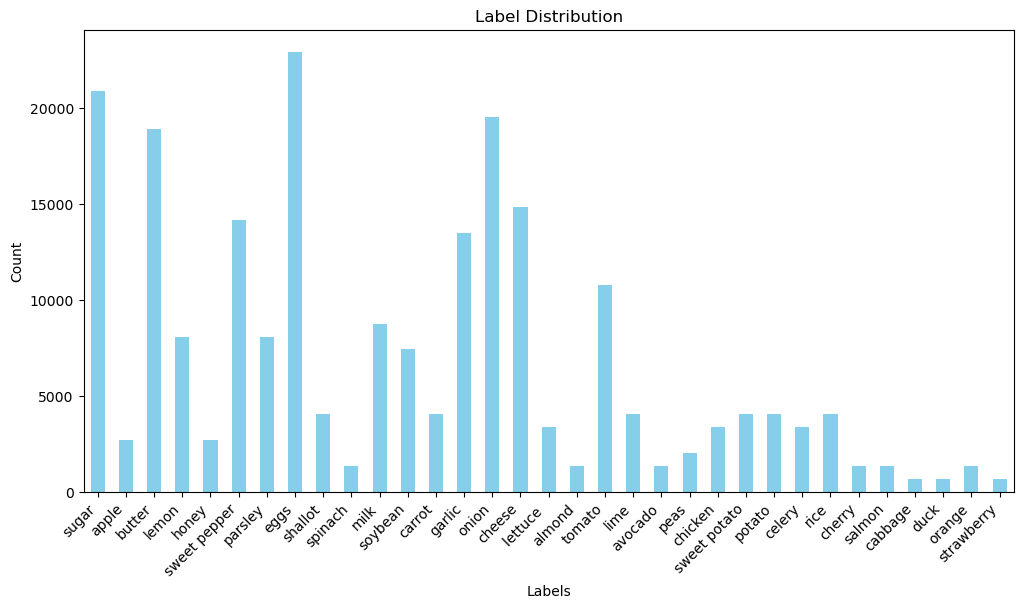

Minimum label count: 675


(33,
 sugar           20925
 apple            2700
 butter          18900
 lemon            8100
 honey            2700
 sweet pepper    14175
 parsley          8100
 eggs            22950
 shallot          4050
 spinach          1350
 milk             8775
 soybean          7425
 carrot           4050
 garlic          13500
 onion           19575
 cheese          14850
 lettuce          3375
 almond           1350
 tomato          10800
 lime             4050
 avocado          1350
 peas             2025
 chicken          3375
 sweet potato     4050
 potato           4050
 celery           3375
 rice             4050
 cherry           1350
 salmon           1350
 cabbage           675
 duck              675
 orange           1350
 strawberry        675
 dtype: int64)

In [29]:
labels = train_df.columns[6:]
label_counts = train_df[labels].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
labels_greater_than_3 = label_counts[(label_counts > 3) & (~np.isnan(label_counts))]

min_label_count = labels_greater_than_3.min()
print("Minimum label count:", min_label_count)

len(labels_greater_than_3), labels_greater_than_3

In [30]:
val_df = prepare_dataset(val_img_df)
test_df = prepare_dataset(test_img_df)

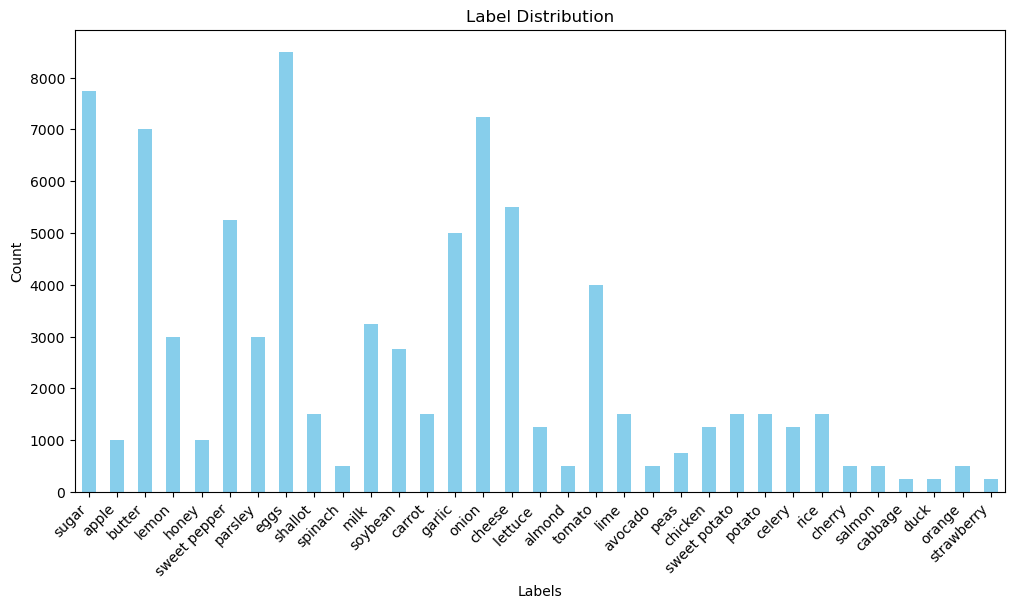

Minimum label count: 250


(33,
 sugar           7750
 apple           1000
 butter          7000
 lemon           3000
 honey           1000
 sweet pepper    5250
 parsley         3000
 eggs            8500
 shallot         1500
 spinach          500
 milk            3250
 soybean         2750
 carrot          1500
 garlic          5000
 onion           7250
 cheese          5500
 lettuce         1250
 almond           500
 tomato          4000
 lime            1500
 avocado          500
 peas             750
 chicken         1250
 sweet potato    1500
 potato          1500
 celery          1250
 rice            1500
 cherry           500
 salmon           500
 cabbage          250
 duck             250
 orange           500
 strawberry       250
 dtype: int64)

In [31]:
labels = test_df.columns[6:]
label_counts = test_df[labels].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
labels_greater_than_3 = label_counts[(label_counts > 3) & (~np.isnan(label_counts))]

min_label_count = labels_greater_than_3.min()
print("Minimum label count:", min_label_count)

len(labels_greater_than_3), labels_greater_than_3

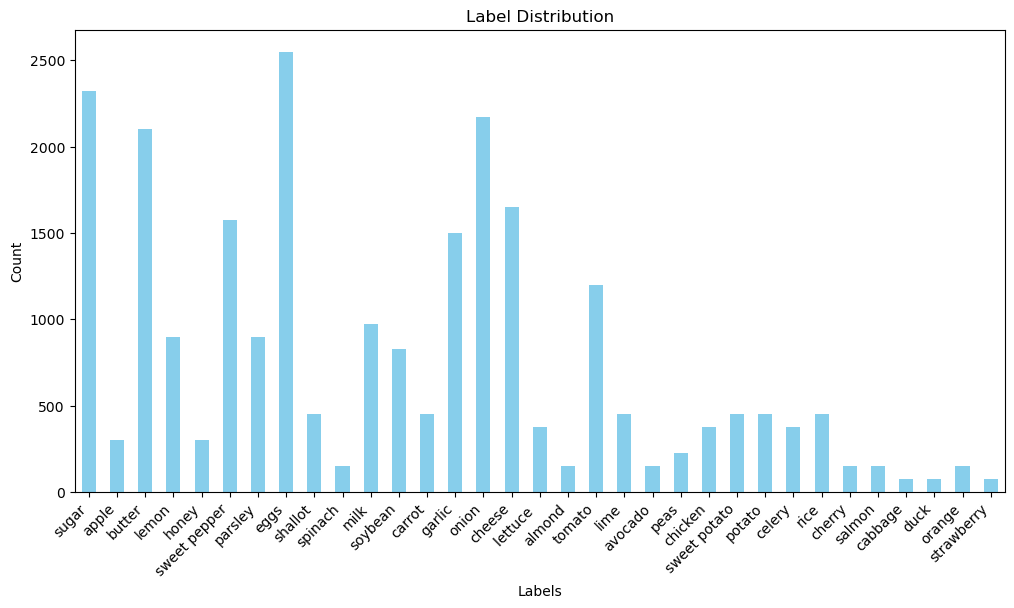

Minimum label count: 75


(33,
 sugar           2325
 apple            300
 butter          2100
 lemon            900
 honey            300
 sweet pepper    1575
 parsley          900
 eggs            2550
 shallot          450
 spinach          150
 milk             975
 soybean          825
 carrot           450
 garlic          1500
 onion           2175
 cheese          1650
 lettuce          375
 almond           150
 tomato          1200
 lime             450
 avocado          150
 peas             225
 chicken          375
 sweet potato     450
 potato           450
 celery           375
 rice             450
 cherry           150
 salmon           150
 cabbage           75
 duck              75
 orange           150
 strawberry        75
 dtype: int64)

In [32]:
labels = val_df.columns[6:]
label_counts = val_df[labels].sum()
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
labels_greater_than_3 = label_counts[(label_counts > 3) & (~np.isnan(label_counts))]

min_label_count = labels_greater_than_3.min()
print("Minimum label count:", min_label_count)

len(labels_greater_than_3), labels_greater_than_3

In [33]:
train_df.to_csv('./data/allergens_train.csv', index=False)
val_df.to_csv('./data/allergens_val.csv', index=False)
test_df.to_csv('./data/allergens_test.csv', index=False)